# Data Analysis

ใน part ที่แล้วเราได้ลองดูตัวอย่างการสำรวจดูข้อมูลจาก 1 subject

สมมติว่าเรามั่นใจแล้วว่าข้อมูลจากทุก subjects ไม่มีปัญหาอะไรร้ายแรง เราสามารถมาลองแก้โจทย์ motor imagery กันโดยใช้ข้อมูลจากหลาย subject มาพัฒนาโมเดล โดยเราจะให้โมเดลตอบให้ได้ว่า time signal แต่ละอัน เป็น event ประเภท hands หรือ event ประเภท feet

In [1]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 22.1 MB/s eta 0:00:00


In [2]:
import pdb
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import colors


from mne import Epochs, pick_types, events_from_annotations, find_events
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci

เราจะเอาคำสั่งสำหรับการ download ข้อมูลและ preprocess ข้อมูลจาก part ที่แล้วมารวมกันในฟังก์ชัน `download_one_subject`

In [3]:
# Download และ preprocess ข้อมูลจากอาสาสมัคร 1 คน
def download_one_subject(subject_id):

    # กำหนดค่าพารามิเตอร์สำหรับโหลดชุดข้อมูลที่เราสนใจ โดยมีรายละเอียดเพิ่มเติมจาก link นี้ https://mne.tools/stable/generated/mne.datasets.eegbci.load_data.html#mne.datasets.eegbci.load_data
    tmin, tmax = -1.0, 4.0
    subject = 1 # เลือก subject ที่เราสนใจ (ค่าตั้งแต่ 1 ถึง 109)
    runs = [6, 10, 14]  # เลือกข้อมูล Motor imagery: hands vs feet 

    # ทำการโหลดข้อมูล ด้วยพารามิเตอร์ที่เรากำหนดไว้ด้านบน
    raw_fnames = eegbci.load_data(subject, runs, verbose='WARNING')
    raw = concatenate_raws([read_raw_edf(f, preload=True, verbose='WARNING') for f in raw_fnames])

    eegbci.standardize(raw)  # set channel names
    montage = make_standard_montage("standard_1005")
    raw.set_montage(montage)

    # เลือกเฉพาะข้อมูล hands กับ feet
    event_id = dict(hands=2, feet=3)

    # Apply band-pass filter
    raw.filter(7.0, 30.0, fir_design="firwin", skip_by_annotation="edge", verbose='WARNING')

    # 
    hands_id = 2
    feet_id = 3
    events, _ = events_from_annotations(raw, event_id=dict(T1=hands_id, T2=feet_id), verbose='WARNING')
    
    # เลือกเก็บเฉพาะข้อมูล EEG และกำจัดข้อมูล electrode ที่มีปัญหา
    picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

    # Read epochs (train will be done only between 1 and 2s)
    # Testing will be done with a running classifier
    epochs = Epochs(
        raw,
        events,
        event_id,
        tmin,
        tmax,
        proj=True,
        picks=picks,
        baseline=None,
        preload=True,
        verbose='WARNING'
    )
    epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)
    labels = epochs.events[:, -1] - 2 # 0: hands, 1: feet

    epochs_data = epochs.get_data()
    epochs_data_truncated = epochs_train.get_data()

    return epochs_data_truncated, labels


ทำการโหลดข้อมูลจากหลาย subjects มารวมกัน

In [5]:
# ระบุจำนวนอาสาสมัคร (subjects) ที่เราต้องการ
num_subjects = 25

data = []
labels = []

for idx_subj in range(num_subjects):

    # Download ข้อมูลทีละ subject
    curr_data, curr_labels = download_one_subject(subject_id=1)

    # นำเอาข้อมูลที่ download มารวมกัน
    data.append(curr_data)
    labels.append(curr_labels)

    # print แสดง progress
    print(f"Done: {idx_subj+1}/{num_subjects}")

# แปลงข้อมูลให้เป็น numpy array
data = np.asarray(data)
labels = np.asarray(labels)

Done: 1/25
Done: 2/25
Done: 3/25
Done: 4/25
Done: 5/25
Done: 6/25
Done: 7/25
Done: 8/25
Done: 9/25
Done: 10/25
Done: 11/25
Done: 12/25
Done: 13/25
Done: 14/25
Done: 15/25
Done: 16/25
Done: 17/25
Done: 18/25
Done: 19/25
Done: 20/25
Done: 21/25
Done: 22/25
Done: 23/25
Done: 24/25
Done: 25/25


ลองดูข้อมูลที่เราโหลดมาว่ามีจำนวนมิติเป็นอย่างไร

In [6]:
print(f"Data shape (# subjects, # trials, # electrodes, # time points): {data.shape}")
print(f"Labels (# subjects, # trials): {labels.shape}")
print(f"Available labels: {set(np.reshape(labels, (-1, )))}")

num_subjects, num_trials, num_electrodes, num_time_pts = data.shape

Data shape (# subjects, # trials, # electrodes, # time points): (25, 45, 64, 161)
Labels (# subjects, # trials): (25, 45)
Available labels: {0, 1}


เราลองเอา time signal จากทุก electrode มาต่อกันยาว ๆ และใช้แต่ละจุดเป็น feature ไปผ่าน PCA ดูกันดีกว่า

In [7]:
data_flatten = np.reshape(data, (num_subjects*num_trials, num_electrodes*num_time_pts))
print(f"Vectorized data (# samples, # features): {data_flatten.shape} ")

Vectorized data (# samples, # features): (1125, 10304) 


% variance captured by PC1 =  13.72
% variance captured by PC2 =  6.29


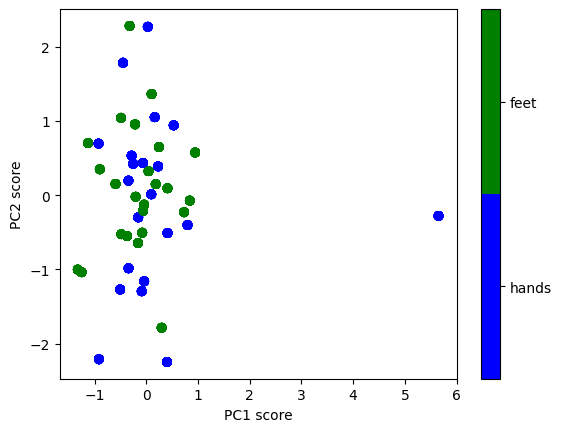

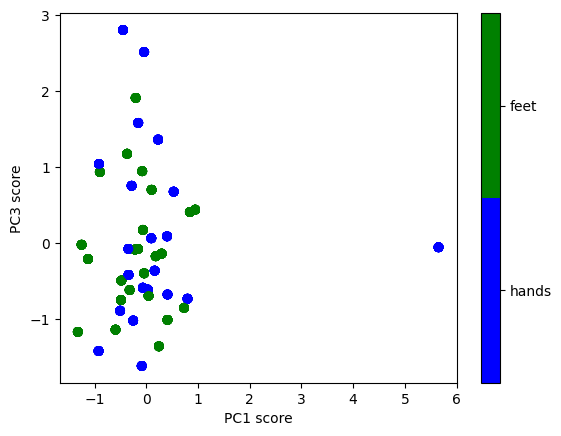

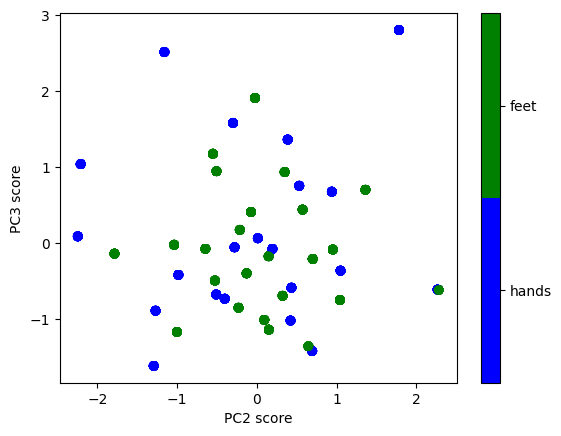

In [11]:
# สร้าง PCA
model_PCA = PCA(n_components=3, whiten=True)
data_PCA = model_PCA.fit_transform(data_flatten)

print(f"% variance captured by PC1 = {model_PCA.explained_variance_ratio_[0]*100: 0.2f}")
print(f"% variance captured by PC2 = {model_PCA.explained_variance_ratio_[1]*100: 0.2f}")

# กำหนดสีให้แต่ละ class โดยใช้สีน้ำเงินพูแสดง class 0 (hands) และสีเขียวแสดง class 1 (feet)
custom_cmap = colors.ListedColormap(["blue","green"]) 

plt.figure()
plt.scatter(data_PCA[:,0], data_PCA[:,1], c=labels, cmap=custom_cmap)
plt.colorbar(boundaries=np.arange(3)-0.5).set_ticks(np.arange(2), labels=['hands', 'feet'])
plt.xlabel('PC1 score')
plt.ylabel('PC2 score')

plt.figure()
plt.scatter(data_PCA[:,0], data_PCA[:,2], c=labels, cmap=custom_cmap)
plt.colorbar(boundaries=np.arange(3)-0.5).set_ticks(np.arange(2), labels=['hands', 'feet'])
plt.xlabel('PC1 score')
plt.ylabel('PC3 score')

plt.figure()
plt.scatter(data_PCA[:,1], data_PCA[:,2], c=labels, cmap=custom_cmap)
plt.colorbar(boundaries=np.arange(3)-0.5).set_ticks(np.arange(2), labels=['hands', 'feet'])
plt.xlabel('PC2 score')
plt.ylabel('PC3 score')
plt.show()

ด้วยเทคนิค PCA ซึ่งเป็นเทคนิคแบบ linear ที่ไม่ได้ใช้ประโยชน์จาก labels (ผลเฉลยว่าข้อมูลไหนเป็น class ใด) จะเห็นว่าข้อมูลไม่กระจายตัวออกจากกัน